# Neural Collaborative Filtering

In [42]:
import pandas as pd
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Multiply, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname="./SimHei.ttf")

def visual_continue(df, func=None):
    ax = sns.distplot(df)
    if func:
        func(ax)
    
    gca = plt.gca()
    fig_title = "Statistics of {}".format(df.name)
    gca.set_title(fig_title, fontsize=14)
    gca.set_ylabel("Density", fontsize=14)
    gca.set_xlabel(df.name, fontsize=14)
    
    plt.show()

## Data Processing

In [44]:
df = pd.read_csv("data/big_matrix.csv")
categories_df = pd.read_csv("data/item_categories.csv")
user_features_df = pd.read_csv("data/user_features.csv")
item_features = pd.read_csv("data/item_daily_features.csv")
test_df = pd.read_csv("data/small_matrix.csv")

In [45]:
for d in [df, categories_df, user_features_df, item_features, test_df]:
    d.dropna(inplace=True)
    d.drop_duplicates(inplace=True)
df = df[df["timestamp"] >= 0]

In [46]:
threshold = 0.9
low_features_cols = []
for col in [c for c in user_features_df.columns]:
    top_freq = user_features_df[col].value_counts(normalize=True).values[0]
    if top_freq >= threshold:
        print(f"Feature {col} has a top frequency of {top_freq}")
        low_features_cols.append(col)

user_features_df.drop(columns=low_features_cols, inplace=True)
user_features_df.drop(columns=[col for col in user_features_df.columns if col.endswith('_range')], inplace=True)

Feature is_lowactive_period has a top frequency of 0.9995651543701985
Feature is_live_streamer has a top frequency of 0.9930424699231772
Feature onehot_feat5 has a top frequency of 0.99898536019713
Feature onehot_feat11 has a top frequency of 0.9282504710827656
Feature onehot_feat14 has a top frequency of 0.9054935497898247
Feature onehot_feat15 has a top frequency of 0.981301637918539
Feature onehot_feat16 has a top frequency of 0.9820263806348746
Feature onehot_feat17 has a top frequency of 0.985505145673286


## Feature Engineering

In [47]:
agg = item_features.groupby("video_id")[[
    'show_cnt', 'play_cnt', 'like_user_num', 'share_cnt', 'comment_cnt',
]].sum()

video_watch_ratio = df.groupby("video_id")['watch_ratio'].mean()
agg = agg.join(video_watch_ratio, on="video_id",how="right")


In [48]:
from sklearn.linear_model import LinearRegression

X = agg[['show_cnt', 'play_cnt', 'like_user_num', 'share_cnt', 'comment_cnt']].fillna(0)

y = agg['watch_ratio'].fillna(0)

model = LinearRegression()
model.fit(X, y)

coeffs = pd.Series(model.coef_, index=X.columns)
print("Learned weights:")
print(coeffs.sort_values(ascending=False))


agg['popularity_score'] = model.predict(X)


Learned weights:
comment_cnt      1.614535e-07
play_cnt         4.957340e-08
show_cnt        -6.881437e-08
like_user_num   -1.382242e-07
share_cnt       -1.935359e-06
dtype: float64


In [49]:
agg = agg['popularity_score']
agg_df = agg.reset_index()
agg_df.columns = ['video_id', 'popularity_score']
agg_df = agg_df.dropna(subset=['video_id'])
agg_df['video_id'] = agg_df['video_id'].astype('int32')

count    10094.000000
mean         1.200544
std          0.144673
min         -2.922962
25%          1.227105
50%          1.245443
75%          1.246344
max          1.248602
Name: popularity_score, dtype: float64


/var/folders/9f/jfpypfpx4y3cgctjsdtf0qhh0000gn/T/ipykernel_53690/718493317.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df)


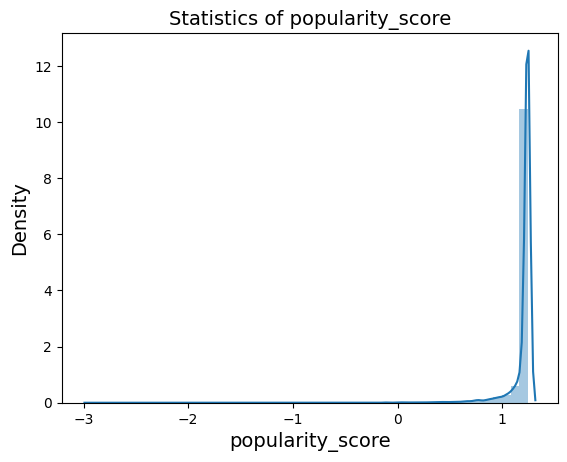

In [21]:
print(agg_df['popularity_score'].describe())
visual_continue(agg_df['popularity_score'])

In [50]:
# Encode tags (0-30) → multi-hot vector
categories_df['feat'] = categories_df['feat'].apply(literal_eval)
mlb = MultiLabelBinarizer(classes=list(range(31)))
tag_matrix = mlb.fit_transform(categories_df['feat'])
tag_df = pd.DataFrame(tag_matrix, columns=[f'tag_{i}' for i in mlb.classes_])
item_cat = pd.concat([categories_df[['video_id']], tag_df], axis=1)

# Encode string user_active_degree to integer codes
user_features_df['user_active_degree'], _ = pd.factorize(user_features_df['user_active_degree'])
for col in user_features_df.columns:
    if col != 'user_id':
        user_features_df[col] = user_features_df[col].astype('int32')

df = df.merge(item_cat, on='video_id').merge(user_features_df, on='user_id').merge(agg_df, on='video_id')
test_df = test_df.merge(item_cat, on='video_id').merge(user_features_df, on='user_id').merge(agg_df, on='video_id')

In [51]:
# Convert the tag columns into a list of multi-hot
tag_cols = [f'tag_{i}' for i in range(31)]
df['tag_multi_hot'] = df[tag_cols].values.tolist()
test_df['tag_multi_hot'] = test_df[tag_cols].values.tolist()

df.drop(columns=tag_cols, inplace=True)
test_df.drop(columns=tag_cols, inplace=True)

In [61]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

count    8.394580e+06
mean     9.749956e-01
std      1.706527e+00
min      0.000000e+00
25%      3.436399e-01
50%      7.526808e-01
75%      1.202427e+00
max      2.669448e+02
Name: watch_ratio, dtype: float64


/var/folders/9f/jfpypfpx4y3cgctjsdtf0qhh0000gn/T/ipykernel_36942/718493317.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df)


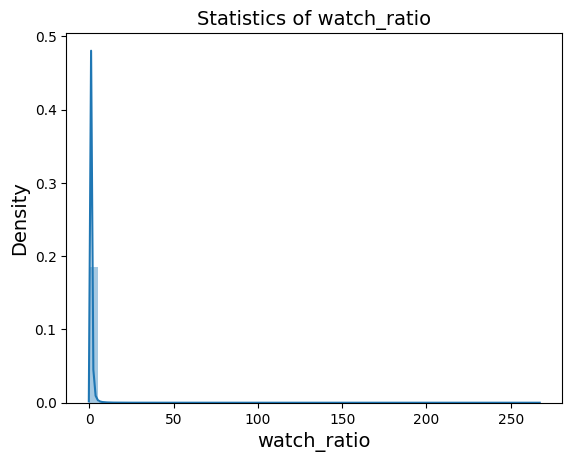

In [13]:
train_watch_ratio = train_df['watch_ratio']
print(train_watch_ratio.describe())
visual_continue(train_watch_ratio)

In [62]:
train_df = train_df[(train_df['watch_ratio'] > 0)]

In [63]:
def preprocess_watch_ratio(df):
    df = df.copy()
    df['rating'] = np.log1p(df['watch_ratio'])  # log(1 + x)
    return df


train_df = preprocess_watch_ratio(train_df)
val_df = preprocess_watch_ratio(val_df)

count    8.228598e+06
mean     5.951294e-01
std      3.806564e-01
min      8.589774e-06
25%      3.145346e-01
50%      5.702574e-01
75%      7.949493e-01
max      5.590781e+00
Name: rating, dtype: float64


<Axes: xlabel='rating', ylabel='Count'>

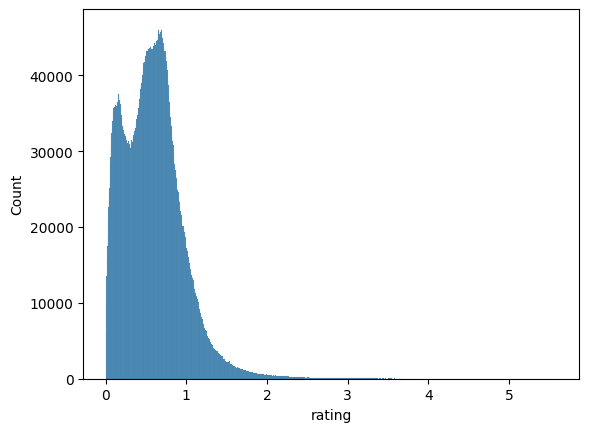

In [16]:
print(train_df['rating'].describe())
sns.histplot(train_df["rating"])

In [18]:
# Prepare tf.data Dataset
def df_to_dataset(df, shuffle=False, batch_size=1024):
    labels = df['rating'].values.astype('float32')
    inputs = {
        col: df[col].values
        for col in ['user_id', 'video_id'] + [c for c in user_features_df.columns if c != 'user_id']
    }
    inputs['popularity_score'] = df['popularity_score'].values.astype('float32')
    inputs['tag_multi_hot'] = np.array(df['tag_multi_hot'].tolist(), dtype='float32')
    ds = tf.data.Dataset.from_tensor_slices((inputs, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)



train_ds = df_to_dataset(train_df, shuffle=True)
val_ds = df_to_dataset(val_df)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8228598 entries, 9451173 to 6423388
Data columns (total 29 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             int64  
 1   video_id            int64  
 2   play_duration       int64  
 3   video_duration      int64  
 4   time                object 
 5   date                int64  
 6   timestamp           float64
 7   watch_ratio         float64
 8   user_active_degree  int32  
 9   is_video_author     int32  
 10  follow_user_num     int32  
 11  fans_user_num       int32  
 12  friend_user_num     int32  
 13  register_days       int32  
 14  onehot_feat0        int32  
 15  onehot_feat1        int32  
 16  onehot_feat2        int32  
 17  onehot_feat3        int32  
 18  onehot_feat4        int32  
 19  onehot_feat6        int32  
 20  onehot_feat7        int32  
 21  onehot_feat8        int32  
 22  onehot_feat9        int32  
 23  onehot_feat10       int32  
 24  onehot_feat12       int

In [20]:
# Determine global vocab sizes
vocab = {}
for col in ['user_id', 'video_id'] + [c for c in user_features_df.columns if c != 'user_id']:
    # calculate max over train+test
    mx = max(train_df[col].max(), val_df[col].max())
    vocab[col] = int(mx) + 1  # input_dim must be max_index+1

In [21]:
n_users = vocab['user_id']
n_items = vocab['video_id']

## Model

In [22]:
class NCFModel:
    def __init__(self, n_users, n_items, vocab, user_features_df):
        self.n_users = n_users
        self.n_items = n_items
        self.vocab = vocab
        self.user_features_df = user_features_df

    def build(self):

        # Inputs
        user_input = Input(shape=(1,), name='user_id')
        item_input = Input(shape=(1,), name='video_id')
        tag_input = Input(shape=(31,), name='tag_multi_hot', dtype='float32')
        popularity_input = Input(shape=(1,), name='popularity_score', dtype='float32')
        uf_input = [Input(shape=(), name=col, dtype='int32') for col in self.user_features_df.columns if col != 'user_id']
        
        # Embeddings
        user_emb = Embedding(self.n_users, 16, name='user_emb')(user_input)
        item_emb = Embedding(self.n_items, 16, name='item_emb')(item_input)

        uf_embs = []
        for inp in uf_input:
            dim = self.vocab[inp.name]
            emb = Embedding(input_dim=dim, output_dim=16)(inp)
            uf_embs.append(Flatten()(emb))

        user_vec = Flatten()(user_emb)
        item_vec = Flatten()(item_emb)
        tag_vec = Dense(32, activation='relu')(tag_input)
        pop_vec = Dense(32, activation='relu')(popularity_input)
        uf_vec = Concatenate()(uf_embs) if uf_embs else None

        # GMF
        gmf_vec = Multiply()([user_vec, item_vec])

        # MLP
        mlp_inputs = [user_vec, item_vec, tag_vec, pop_vec]
        if uf_vec is not None:
            mlp_inputs.append(uf_vec)
        mlp_vec = Concatenate()(mlp_inputs)
        for i in [32, 16, 8]:
            mlp_vec = Dense(i, activation='relu', name=f'mlp_dense_{i}')(mlp_vec)
            mlp_vec = BatchNormalization(name=f'bn_{i}')(mlp_vec)
            mlp_vec = Dropout(0.1, name=f'dropout_{i}')(mlp_vec)

        # Final output
        concat = Concatenate()([gmf_vec, mlp_vec])
        output = Dense(1, activation='linear', name='prediction')(concat)

        model = Model(inputs=[user_input, item_input, tag_input, popularity_input] + uf_input, outputs=output)
        model.compile(
            optimizer=Adam(learning_rate=0.01),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return model

In [23]:
ncf = NCFModel(n_users, n_items, vocab, user_features_df)
model = ncf.build()


In [24]:
stop_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[stop_early]
)

Epoch 1/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 167s 20ms/step - loss: 0.1229 - mae: 0.2421 - mse: 0.1229 - val_loss: 0.1107 - val_mae: 0.2289 - val_mse: 0.1107
Epoch 2/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 163s 20ms/step - loss: 0.1059 - mae: 0.2226 - mse: 0.1059 - val_loss: 0.1108 - val_mae: 0.2294 - val_mse: 0.1108
Epoch 3/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 166s 21ms/step - loss: 0.1044 - mae: 0.2200 - mse: 0.1044 - val_loss: 0.1107 - val_mae: 0.2290 - val_mse: 0.1107
Epoch 4/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 171s 21ms/step - loss: 0.1037 - mae: 0.2190 - mse: 0.1037 - val_loss: 0.1111 - val_mae: 0.2280 - val_mse: 0.1111
Epoch 5/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 168s 21ms/step - loss: 0.1032 - mae: 0.2183 - mse: 0.1032 - val_loss: 0.1115 - val_mae: 0.2304 - val_mse: 0.1115
Epoch 6/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 169s 21ms/step - loss: 0.1028 - mae: 0.2179 - mse: 0.1028 - val_loss: 0.1105 - val_mae: 0.2266 - val_mse: 0.1105
Epoch 7/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 171s 21ms/step - loss: 0.102

In [28]:
model.save('trained_models/NCF-extended.keras')

In [52]:
model = tf.keras.models.load_model('trained_models/NCF-extended.keras')

## Top-K Performance Evaluation

In [53]:
from sklearn.metrics import ndcg_score

def compute_ndcg(top_k_preds, ranked_items, true_watch_ratios, k):
    relevance = [true_watch_ratios.get(item, 0.0) for item in ranked_items[:k]]
    return ndcg_score([relevance], [top_k_preds])

def compute_mae_rmse(top_k_preds, top_k_items, true_watch_ratios):
    top_k_true = np.array([true_watch_ratios.get(item, 0.0) for item in top_k_items])
    abs_errors = np.abs(top_k_true - top_k_preds)
    sq_errors = (top_k_true - top_k_preds) ** 2
    mae = np.mean(abs_errors)
    rmse = np.sqrt(np.mean(sq_errors))
    return mae, rmse

def compute_popularity(top_k_popularity):
    return np.mean(top_k_popularity)

def compute_serendipity(top_k_items, true_watch_ratios, top_k_popularity):
    max_popularity = top_k_popularity.max() if len(top_k_popularity) > 0 else 1.0

    serendipities = []
    for i, item_id in enumerate(top_k_items):
        relevance = 1.0 if true_watch_ratios.get(item_id, 0.0) > 0 else 0.0
        unexpectedness = 1.0 - (top_k_popularity[i] / max_popularity)
        serendipity = relevance * unexpectedness
        serendipities.append(serendipity)

    return np.mean(serendipities) if serendipities else 0.0

In [ ]:
from scipy.stats import spearmanr
def evaluate_model_at_k(model, df_test, user_feat, k=10):

    all_user_ids = df_test['user_id'].unique()
    ndcg_list = []
    popularity_list = []
    serendipity_list = []
    mae_list = []
    rmse_list = []
    spearman_list = []

    for user_id in all_user_ids:
        user_df = df_test[df_test['user_id'] == user_id]
        if user_df.empty:
            continue

        true_watch_ratios = {row['video_id']: row['watch_ratio'] for _, row in user_df.iterrows()}
        if all(watch_ratio == 0 for watch_ratio in true_watch_ratios.values()):
            continue

        user_inputs = {
            'user_id': np.full(len(user_df), user_id, dtype='int32'),
            'video_id': user_df['video_id'].values.astype('int32'),
            'popularity_score': user_df['popularity_score'].values.astype('float32'),
            'tag_multi_hot': np.array(user_df['tag_multi_hot'].tolist(), dtype='float32'),
        }

        for col in user_feat.columns:
            if col != 'user_id':
                val = user_df[col].values.astype('int32')
                user_inputs[col] = val

        preds = np.expm1(model.predict(user_inputs, verbose=0).flatten())

        ranked_indices = np.argsort(-preds)
        ranked_items = user_df['video_id'].values[ranked_indices]
        top_k_items = ranked_items[:k]
        top_k_preds = preds[ranked_indices][:k]

        top_k_popularity = user_df.iloc[ranked_indices[:k]]['popularity_score'].values

        mae, rmse = compute_mae_rmse(top_k_preds, top_k_items, true_watch_ratios)
        ndcg = compute_ndcg(top_k_preds, ranked_items, true_watch_ratios, k)
        popularity = compute_popularity(top_k_popularity)
        serendipity = compute_serendipity(top_k_items, true_watch_ratios, top_k_popularity)

        true_scores = np.array([true_watch_ratios.get(vid, 0.0) for vid in user_df['video_id'].values])
        if np.std(preds) == 0:
            spearman_corr = 0.0
        else:
            spearman_corr, _ = spearmanr(true_scores, preds)
        if not np.isnan(spearman_corr):
            spearman_list.append(spearman_corr)

        mae_list.append(mae)
        rmse_list.append(rmse)
        ndcg_list.append(ndcg)
        popularity_list.append(popularity)
        serendipity_list.append(serendipity)

    print(f'NDCG@{k}:             {np.mean(ndcg_list):.4f}')
    print(f'MAE@{k}:              {np.mean(mae_list):.4f}')
    print(f'RMSE@{k}:             {np.mean(rmse_list):.4f}')
    print(f'Serendipity@{k}:      {np.mean(serendipity_list):.4f}')
    print(f'Average Popularity@{k}: {np.mean(popularity_list):.4f}')
    print(f'Spearman Rank Correlation: {np.mean(spearman_list):.4f}')

In [67]:
evaluate_model_at_k(model, test_df, user_features_df)

NDCG@10:             0.8811
MAE@10:              0.9141
RMSE@10:             1.3063
Serendipity@10:      0.0150
Average Popularity@10: 1.2263
Spearman Rank Correlation: 0.6201


In [68]:
evaluate_model_at_k(model, test_df, user_features_df, k=20)

NDCG@20:             0.8659
MAE@20:              0.8546
RMSE@20:             1.3293
Serendipity@20:      0.0208
Average Popularity@20: 1.2200
Spearman Rank Correlation: 0.6201


## NCF Hyperparameter Optimizer

In [36]:
class NCFHyperModel(kt.HyperModel):
    def __init__(self, n_users, n_items, vocab, user_features_df):
        self.n_users = n_users
        self.n_items = n_items
        self.vocab = vocab
        self.user_features_df = user_features_df

    def build(self, hp):
        # Hyperparams
        embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=32, step=16)
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)

        # Inputs
        user_input = Input(shape=(1,), name='user_id')
        item_input = Input(shape=(1,), name='video_id')
        tag_input = Input(shape=(31,), name='tag_multi_hot', dtype='float32')
        popularity_input = Input(shape=(1,), name='popularity_score', dtype='float32')
        uf_input = [Input(shape=(), name=col, dtype='int32') for col in self.user_features_df.columns if col != 'user_id']

        # Embeddings
        user_emb = Embedding(self.n_users, embedding_dim, name='user_emb')(user_input)
        item_emb = Embedding(self.n_items, embedding_dim, name='item_emb')(item_input)

        uf_embs = []
        for inp in uf_input:
            dim = self.vocab[inp.name]
            emb = Embedding(input_dim=dim, output_dim=embedding_dim)(inp)
            uf_embs.append(Flatten()(emb))

        user_vec = Flatten()(user_emb)
        item_vec = Flatten()(item_emb)
        tag_vec = Dense(32, activation='relu')(tag_input)
        pop_vec = Dense(32, activation='relu')(popularity_input)
        uf_vec = Concatenate()(uf_embs) if uf_embs else None

        # GMF
        gmf_vec = Multiply()([user_vec, item_vec])

        # MLP
        mlp_inputs = [user_vec, item_vec, tag_vec, pop_vec]
        if uf_vec is not None:
            mlp_inputs.append(uf_vec)
        mlp_vec = Concatenate()(mlp_inputs)

        for i in [256, 128, 64]:
            mlp_vec = Dense(i, activation='relu')(mlp_vec)
            mlp_vec = BatchNormalization()(mlp_vec)
            mlp_vec = Dropout(dropout_rate)(mlp_vec)

        # Final output
        concat = Concatenate()([gmf_vec, mlp_vec])
        output = Dense(1, activation='linear', name='prediction')(concat)

        model = Model(inputs=[user_input, item_input, tag_input, popularity_input] + uf_input, outputs=output)
        model.compile(
            optimizer=Adam(learning_rate=0.01),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return model


In [35]:
n_users = vocab['user_id']
n_items = vocab['video_id']

In [37]:
hypermodel = NCFHyperModel(n_users=n_users, n_items=n_items, vocab=vocab, user_features_df=user_features_df)
tuner = kt.Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=5,
    directory='hp_optimizer/hp_tuning_extended',
    project_name='ncf_model_tuning_extended',
)

In [38]:
# Search for the best hyperparameters if you haven't already
stop_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tuner.search(
    train_ds,
    validation_data=val_ds,
    callbacks=[stop_early]
)

Trial 10 Complete [00h 34m 24s]
val_loss: 0.11142351478338242

Best val_loss So Far: 0.10945849865674973
Total elapsed time: 02h 50m 14s


In [39]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Meilleurs hyperparamètres :", best_hps.values)

best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[stop_early]
)

Meilleurs hyperparamètres : {'embedding_dim': 16, 'dropout_rate': 0.2, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0003'}
Epoch 1/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 280s 34ms/step - loss: 0.1038 - mae: 0.2191 - mse: 0.1038 - val_loss: 0.1103 - val_mae: 0.2269 - val_mse: 0.1103
Epoch 2/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 287s 36ms/step - loss: 0.1034 - mae: 0.2187 - mse: 0.1034 - val_loss: 0.1092 - val_mae: 0.2244 - val_mse: 0.1092
Epoch 3/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 291s 36ms/step - loss: 0.1031 - mae: 0.2184 - mse: 0.1031 - val_loss: 0.1105 - val_mae: 0.2273 - val_mse: 0.1105
Epoch 4/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 244s 30ms/step - loss: 0.1027 - mae: 0.2180 - mse: 0.1027 - val_loss: 0.1108 - val_mae: 0.2261 - val_mse: 0.1108
Epoch 5/10
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 260s 32ms/step - loss: 0.1025 - mae: 0.2177 - mse: 0.1025 - val_loss: 0.1110 - val_mae: 0.2269 - val_mse: 0.1110


In [ ]:
best_model.save('trained_models/NCF-HP-extended.keras')

In [5]:
best_model = tf.keras.models.load_model('trained_models/NCF-HP-extended.keras')

In [24]:
evaluate_model_at_k(best_model, test_df, user_features_df)

NDCG@10:             0.8772
MAE@10:              0.9249
RMSE@10:             1.3514
Serendipity@10:      0.0128
Average Popularity@10: 1.2288


In [25]:
evaluate_model_at_k(best_model, test_df, user_features_df, k=20)

NDCG@20:             0.8636
MAE@20:              0.8696
RMSE@20:             1.3855
Serendipity@20:      0.0177
Average Popularity@20: 1.2239


# Baseline Model for Comparison

In [69]:
global_mean = np.log1p(train_df['watch_ratio'].mean())
class GlobalMeanBaseline:
    def __init__(self):
        self.global_mean = global_mean

    def predict(self, inputs, verbose=0):
        n = len(inputs['user_id'])
        return np.full(shape=(n,), fill_value=self.global_mean)


In [ ]:
baseline_model = GlobalMeanBaseline()
evaluate_model_at_k(baseline_model, test_df, user_features_df)

NDCG@10:             0.8142 \
MAE@10:              0.5043 \
RMSE@10:             0.6945 \
Serendipity@10:      0.1243 \
Average Popularity@10: 1.0871 \
Spearman Rank Correlation: 0.0000

In [ ]:
evaluate_model_at_k(baseline_model, test_df, user_features_df, k=20)

NDCG@20:             0.7887 \
MAE@20:              0.4947 \
RMSE@20:             0.7094 \
Serendipity@20:      0.1295 \
Average Popularity@20: 1.0828 \
Spearman Rank Correlation: 0.0000

In [ ]:
class PopularityBaseline:
    def __init__(self, test_df, k=10):
        self.k = k
        self.popularity_map = (
            test_df.groupby('video_id')['popularity_score']
            .mean()
            .to_dict()
        )

    def predict(self, inputs, verbose=0):
        video_ids = inputs['video_id']
        video_scores = np.array([self.popularity_map.get(vid, 0.0) for vid in video_ids])
        return video_scores

In [77]:
popularity_model = PopularityBaseline(test_df)
evaluate_model_at_k(popularity_model, test_df, user_features_df)

NDCG@10:             0.7905
MAE@10:              1.5349
RMSE@10:             1.7366
Serendipity@10:      0.0000
Average Popularity@10: 1.2464
Spearman Rank Correlation: 0.2454


# Generate top k videos

In [ ]:
def generate_top_k_recommendations(test_df, user_features_df, model, k=10):
    """
    Generates the top-k recommended videos for each user in test_df.

    Parameters:
    - test_df: DataFrame containing test data (must include user_id, video_id, score_popularity, tag_multi_hot)
    - user_features_df: DataFrame containing user features
    - model: trained model with a .predict method
    - k: number of recommendations to return per user

    Returns:
    - top_k_df: DataFrame containing user_id and their list of top_k_videos
    """
    top_k_videos = []

    for user_id in test_df['user_id'].unique():
        user_df = test_df[test_df['user_id'] == user_id]

        user_inputs = {
            'user_id': np.full(len(user_df), user_id, dtype='int32'),
            'video_id': user_df['video_id'].values.astype('int32'),
            'popularity_score': user_df['popularity_score'].values.astype('float32'),
            'tag_multi_hot': np.stack(user_df['tag_multi_hot'].values)
        }

        for col in user_features_df.columns:
            if col != 'user_id':
                val = user_df[col].values.astype('int32')
                user_inputs[col] = val

        preds = model.predict(user_inputs, verbose=0).flatten()
        sorted_indices = np.argsort(-preds)
        ranked_items = user_df['video_id'].values[sorted_indices]
        top_k_items = ranked_items[:k]

        top_k_videos.append({'user_id': user_id, 'top_k_videos': top_k_items.tolist()})

    top_k_videos = sorted(top_k_videos, key=lambda x: x['user_id'])
    top_k_df = pd.DataFrame(top_k_videos)
    return top_k_df


In [37]:
def get_zero_watch_ratio_inputs(df):
    zero_df = df[df['watch_ratio'] == 0]
    return zero_df

zero_watch_inputs_train = get_zero_watch_ratio_inputs(df)
zero_watch_inputs_test = get_zero_watch_ratio_inputs(test_df)

zero_watch_inputs = pd.concat([zero_watch_inputs_train, zero_watch_inputs_test])


In [ ]:
top_k_df = generate_top_k_recommendations(zero_watch_inputs, model)

In [27]:
top_k_df

,user_id,top_k_videos
0,0,"[1871, 3338, 7157, 8629, 2314, 6716, 1158, 117..."
1,1,"[1116, 4475, 9622, 525, 4325, 4554, 4554, 4416..."
2,2,"[7451, 7657]"
3,3,"[8298, 723, 4932, 4152, 7670, 1565, 3128, 5252..."
4,4,[3089]
...,...,...
6241,7170,"[9645, 10374, 4735, 774, 5777, 8475, 9916, 400..."
6242,7172,"[6977, 7031, 7031, 2631, 1452, 6630, 856, 6063..."
6243,7173,"[6849, 2007, 264]"
6244,7174,"[3722, 1518, 684, 8942, 5729, 9059, 2650, 9871..."


In [ ]:
top_k_df.to_csv('top_k_recommendations.csv')